In [1]:
# Imports
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from math import floor, log, sqrt
from numbers import Number
from statsmodels.graphics.tsaplots import plot_acf
import pymc3 as pm
import arviz as az

C:\Users\User.DESKTOP-IVGA5BC\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd
raw_dat = pd.read_table(r'C:\Users\User\Desktop\COUP551_rates.dat', sep='\s+')

In [3]:
data = pd.DataFrame(raw_dat, columns=["Cts"])
print("The shape of the data is ", data.shape)
print("The name of columns of data is ", data.columns)
data.describe
chptdat = pd.read_table(r'COUP551_rates.dat', sep='\s+')
Y = chptdat['Cts']

The shape of the data is  (46, 1)
The name of columns of data is  Index(['Cts'], dtype='object')


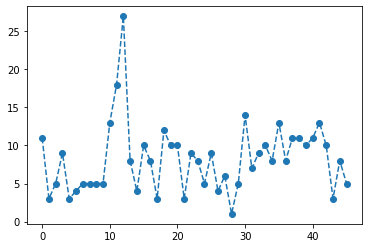

In [4]:
import matplotlib.pyplot as plt
plt.plot(data, "--o")
plt.show()
train_dat = data["Cts"]

Case 1: Here we sample theta, lambda, b1 and b2 by gibbs sampler methods\
k is sampled using metropolis hastings because the 
full conditional distribution of k is not easy to sample from. 

# Case 1a: Here we do fix k

In [5]:
# Programming an MCMC algorithm in Python
# MCMC algorithm for a Bayesian single change point model

KGUESS = 10

def mhsampler(NUMIT=1000, dat=Y):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((5, NUMIT))
    acc = 0 # count number of accepted proposals (for k only)
    
    # starting values for markov chain
    kinit = floor(n/2) # approximately halfway between 0 and n
    mchain[:,0] = np.array([1, 1, kinit, 1, 1])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currtheta = mchain[0, i-1]
        currlambda = mchain[1, i-1]
        currk = mchain[2, i-1]
        currb1 = mchain[3, i-1]
        currb2 = mchain[4, i-1]
        
        # sample from full conditional distribution of theta (Gibbs update)
        currtheta = np.random.gamma(shape=sum(Y.iloc[:int(currk)+1])+0.5, scale=currb1/(currk*currb1 + 1))
        
        # sample from full conditional distribution of lambda (Gibbs update)
        currlambda = np.random.gamma(shape=sum(Y.iloc[int(currk)+1:])+0.5, scale=currb2/((n-currk)*currb2+1))
        
        # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk = np.random.randint(1, n-1)  # draw one sample at random from uniform{1,...,n-1}
        
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk)+1])*log(currtheta) + sum(Y.iloc[int(propk)+1:])*log(currlambda) - propk*currtheta 
                     - (n-propk)*currlambda - (sum(Y.iloc[:int(currk)+1])*log(currtheta) + sum(Y.iloc[int(currk)+1:])*log(currlambda) 
                                               - currk*currtheta - (n-currk)*currlambda))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc += 1
            currk = propk
        
        currk = KGUESS  # we do not sample k (k fixed)
        
        # sample from full conditional distribution of b1 (Gibbs update): draw from Inverse Gamma
        currb1 = 1/np.random.gamma(shape=0.5, scale=1/(currtheta+1))
        
        # sample from full conditional distribution of b2 (Gibbs update): draw from Inverse Gamma
        currb2 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda+1))
        
        # update chain with new values
        mchain[:,i] = np.array([currtheta, currlambda, currk, currb1, currb2])
        
    print(f"Markov chain algorithm ran for {NUMIT} iterations (acc.rate for k = {acc/(NUMIT-1)})")
    print("Parameters are in order: theta, lambda, k, b1, b2")
    return mchain

In [6]:
mchain = mhsampler(NUMIT=100000, dat=Y)
mchain

n= 46
Markov chain algorithm ran for 100000 iterations (acc.rate for k = 0.2032520325203252)
Parameters are in order: theta, lambda, k, b1, b2


array([[  1.        ,   7.89512592,   6.50720167, ...,   6.98641607,
          5.482923  ,   6.71152854],
       [  1.        ,   6.84652389,   8.95732211, ...,   8.64462911,
          8.22765028,   8.66098344],
       [ 23.        ,  10.        ,  10.        , ...,  10.        ,
         10.        ,  10.        ],
       [  1.        ,  23.92152064,  12.14809425, ..., 120.1967741 ,
         22.5065404 ,  20.84878655],
       [  1.        ,  14.74014041,   5.93017962, ...,  58.1541643 ,
          7.44364223,   4.17486895]])

Acceptance rate = 20%

In [7]:
# Batch means
# Function for computing consistent batch means estimate of standard error

def bm(vals, bs="sqroot", warn=False):
    N = vals.size
    if N < 1000:
        if warn:
            print("WARNING: too few samples (less than 1000)")
        if N < 10:
            raise NotImplemented("NA")
    if bs == "sqroot":
        b = floor(sqrt(N))  # batch size
        a = floor(N/b)  # number of batches
    elif bs == "cuberoot":
        b = floor(N**(1/3))  # batch size
        a = floor(N/b)  # number of batches
    else:
        # batch size provided
        if not isinstance(bs, Number):
            raise NotImplemented("NA")
        b = floor(bs)  # batch size
        if b > 1:  # batch size valid
            a = floor(n/b)  # number of batches
        else:
            raise NotImplemented(f"Batch size invalid: bs = {bs}")
    function = lambda k : np.mean(vals[((k-1)*b+1):(k*b+1)])
    Ys = [function(i) for i in range(1, a+1)]
    
    muhat = np.mean(Ys)
    sigmahatsq = b*sum((Ys-muhat)**2)/(a-1)
    
    bmse = sqrt(sigmahatsq/N)
    
    return [f"est={muhat}", f"se={bmse}"]

In [8]:
# Batch means
# Plot how Monte Carlo estimates change with increase in sample size

def estvssamp(samp, g=np.mean):
    if samp.size < 100:
        batchsize = 1
    else:
        batchsize = samp.size//100
    
    est = np.array([])
    for i in range(batchsize, samp.size+1, batchsize):
        est = np.append(est, g(samp[:i]))
    plt.figure()
    plt.plot(est)
    plt.title(f"Monte Carlo estimates with increasing samples (incr of {batchsize})")
    plt.figure()
    plt.plot(range(batchsize, samp.size+1, batchsize), est, '-')
    plt.title("Monte Carlo estimates vs sample size")

Graphs of monte carlo estimates with increasing samples

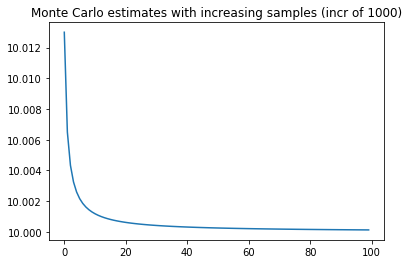

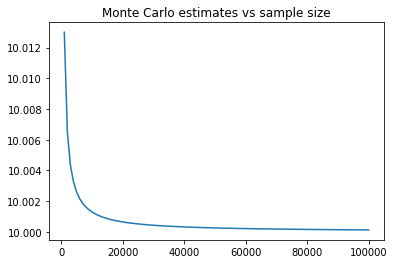

In [9]:
estvssamp(mchain[2,:])

Traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000240258FF888>,
      dtype=object)

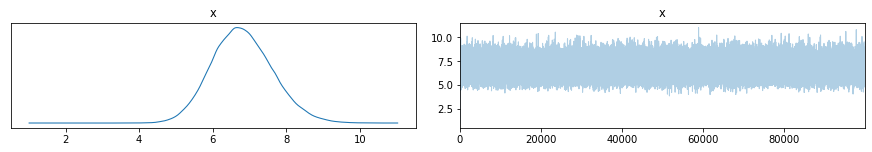

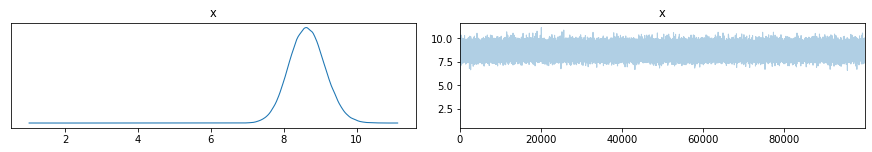

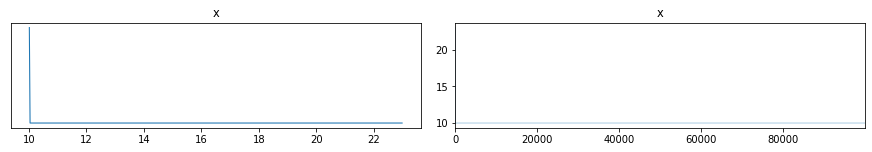

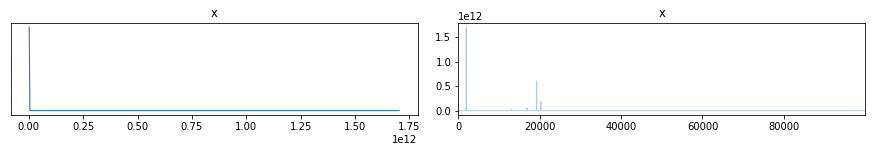

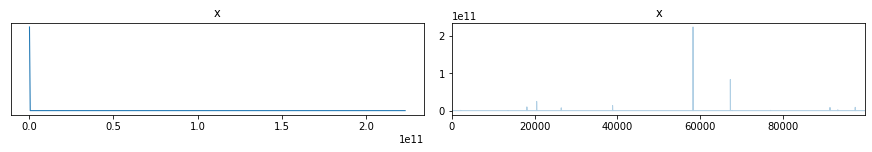

In [10]:
from arviz import plot_trace
plot_trace(mchain[0])
plot_trace(mchain[1])
plot_trace(mchain[2])
plot_trace(mchain[3])
plot_trace(mchain[4])

Calculating the mean of the parameters.

In [11]:
print("Mean of first row (theta)is now", np.mean(mchain[0,:]))
print("Mean of second row (lambda)is now", np.mean(mchain[1,:]))
print("Mean of third row (changepoint)is now", np.mean(mchain[2,:]))
print("Mean of fourth row (b1)is now", np.mean(mchain[3,:]))
print("Mean of fifth row (b2)is now", np.mean(mchain[4,:]))

Mean of first row (theta)is now 6.810985363054208
Mean of second row (lambda)is now 8.642406628447995
Mean of third row (changepoint)is now 10.00013
Mean of fourth row (b1)is now 26429142.899867587
Mean of fifth row (b2)is now 3886760.6874994948


Calculating the mean of the parameters. Here take the last 1000 samples only

In [12]:
print("Mean of first row (theta)is now", np.mean(mchain[0,9000:]))
print("Mean of second row (lambda)is now", np.mean(mchain[1,9000:]))
print("Mean of third row (changepoint)is now", np.mean(mchain[2,9000:]))
print("Mean of fourth row (b1)is now", np.mean(mchain[3,9000:]))
print("Mean of fifth row (b2)is now", np.mean(mchain[4,9000:]))

Mean of first row (theta)is now 6.811466052191984
Mean of second row (lambda)is now 8.642877335053521
Mean of third row (changepoint)is now 10.0
Mean of fourth row (b1)is now 9824159.547810597
Mean of fifth row (b2)is now 4260950.363585156


Smoothed density plots for parameters posterior

In [13]:
mchain_dataframe = pd.DataFrame(mchain)

Text(0.5, 1.0, 'smoothed density plot for theta posterior')

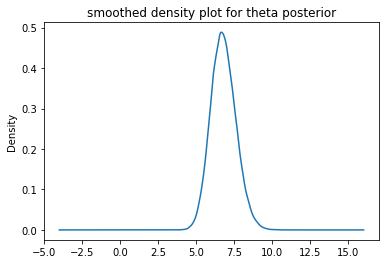

In [14]:
plt.figure()
mchain_dataframe.iloc[0,:].plot(kind="density")
plt.title("smoothed density plot for theta posterior")

Text(0.5, 1.0, 'smoothed density plot for lambda posterior')

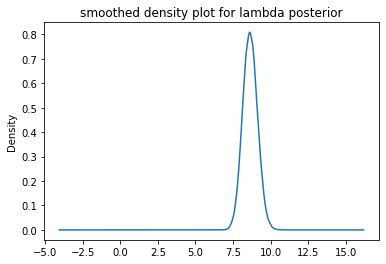

In [15]:
plt.figure()
mchain_dataframe.iloc[1,:].plot(kind="density")
plt.title("smoothed density plot for lambda posterior")

Text(0.5, 1.0, 'histogram for k posterior')

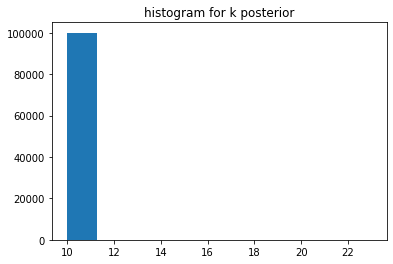

In [16]:
plt.figure()
plt.hist(mchain[2,:])
plt.title("histogram for k posterior")

In [17]:
# find the posterior probability that lambda is greater than 10
boolean2 = [i for i in mchain[1,:] if i > 10]
print("posterior probability that lambda is greater than 10 is", len(boolean2)/len(mchain[1,:]))

posterior probability that lambda is greater than 10 is 0.00373


# Case 1b: Here we do not fix k

In [18]:
# Programming an MCMC algorithm in Python
# MCMC algorithm for a Bayesian single change point model with k also sampled

KGUESS = 10

def mhsampler_ksampled(NUMIT=1000, dat=Y):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((5, NUMIT))
    acc = 0 # count number of accepted proposals (for k only)
    
    # starting values for markov chain
    kinit = floor(n/2) # approximately halfway between 0 and n
    mchain[:,0] = np.array([1, 1, kinit, 1, 1])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currtheta = mchain[0, i-1]
        currlambda = mchain[1, i-1]
        currk = mchain[2, i-1]
        currb1 = mchain[3, i-1]
        currb2 = mchain[4, i-1]
        
        # sample from full conditional distribution of theta (Gibbs update)
        currtheta = np.random.gamma(shape=sum(Y.iloc[:int(currk)])+0.5, scale=currb1/(currk*currb1 + 1))
        
        # sample from full conditional distribution of lambda (Gibbs update)
        currlambda = np.random.gamma(shape=sum(Y.iloc[int(currk):])+0.5, scale=currb2/((n-currk)*currb2+1))
        
        # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk = np.random.randint(1, n-1)  # draw one sample at random from uniform{1,...,n-1}
        
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk)])*log(currtheta) + sum(Y.iloc[int(propk):])*log(currlambda) - propk*currtheta 
                     - (n-propk)*currlambda - (sum(Y.iloc[:int(currk)])*log(currtheta) + sum(Y.iloc[int(currk):])*log(currlambda) 
                                               - currk*currtheta - (n-currk)*currlambda))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc += 1
            currk = propk
        
        # currk = KGUESS  # now we do sample k (k not fixed)
        
        # sample from full conditional distribution of b1 (Gibbs update): draw from Inverse Gamma
        currb1 = 1/np.random.gamma(shape=0.5, scale=1/(currtheta+1))
        
        # sample from full conditional distribution of b2 (Gibbs update): draw from Inverse Gamma
        currb2 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda+1))
        
        # update chain with new values
        mchain[:,i] = np.array([currtheta, currlambda, currk, currb1, currb2])
        
    print(f"Markov chain algorithm ran for {NUMIT} iterations (acc.rate for k = {acc/(NUMIT-1)})")
    print("Parameters are in order: theta, lambda, k, b1, b2")
    return mchain

In [19]:
mchain_ksampled = mhsampler_ksampled(NUMIT=100000, dat=Y)

n= 46
Markov chain algorithm ran for 100000 iterations (acc.rate for k = 0.08551085510855108)
Parameters are in order: theta, lambda, k, b1, b2


acceptance rate = 8.5%

Monte Carlo Estimates vs sample size plots for changepoints

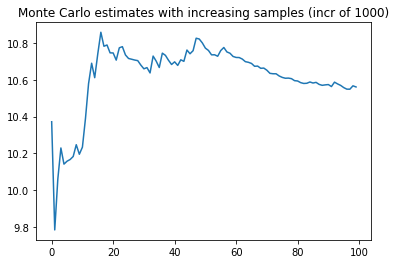

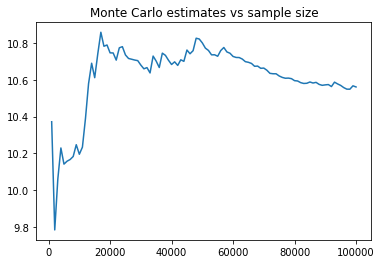

In [20]:
estvssamp(mchain_ksampled[2,:])

Traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000240259E7048>,
      dtype=object)

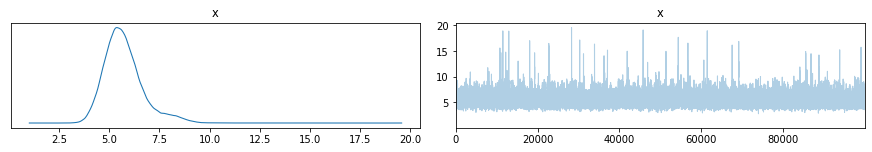

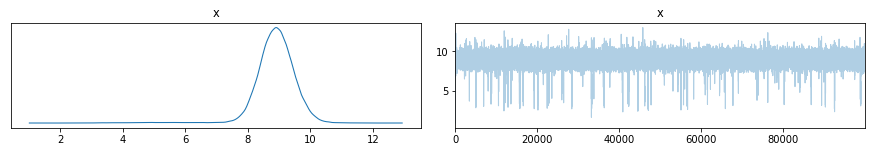

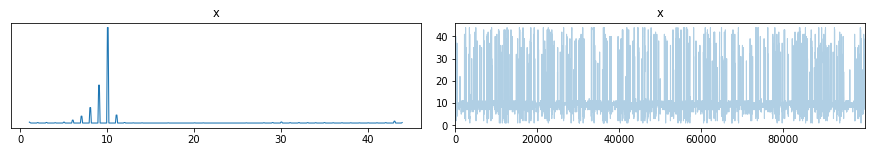

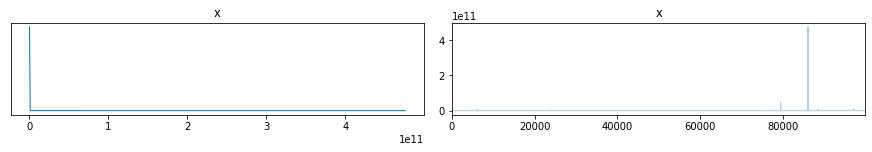

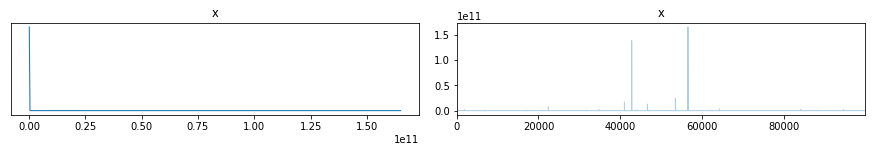

In [21]:
from arviz import plot_trace
plot_trace(mchain_ksampled[0])
plot_trace(mchain_ksampled[1])
plot_trace(mchain_ksampled[2])
plot_trace(mchain_ksampled[3])
plot_trace(mchain_ksampled[4])

Calculating the mean of the parameters.

In [22]:
print("Mean of first row (theta)is now", np.mean(mchain_ksampled[0,:]))
print("Mean of second row (lambda)is now", np.mean(mchain_ksampled[1,:]))
print("Mean of third row (changepoint)is now", np.mean(mchain_ksampled[2,:]))
print("Mean of fourth row (b1)is now", np.mean(mchain_ksampled[3,:]))
print("Mean of fifth row (b2)is now", np.mean(mchain_ksampled[4,:]))

Mean of first row (theta)is now 5.729172068419079
Mean of second row (lambda)is now 8.871675727253391
Mean of third row (changepoint)is now 10.56114
Mean of fourth row (b1)is now 5718032.784417781
Mean of fifth row (b2)is now 3896767.099562701


Calculating the mean of the parameters. Here take the last 1000 samples only

In [23]:
print("Mean of first row (theta)is now", np.mean(mchain_ksampled[0,9000:]))
print("Mean of second row (lambda)is now", np.mean(mchain_ksampled[1,9000:]))
print("Mean of third row (changepoint)is now", np.mean(mchain_ksampled[2,9000:]))
print("Mean of fourth row (b1)is now", np.mean(mchain_ksampled[3,9000:]))
print("Mean of fifth row (b2)is now", np.mean(mchain_ksampled[4,9000:]))

Mean of first row (theta)is now 5.734512026016109
Mean of second row (lambda)is now 8.86789061290431
Mean of third row (changepoint)is now 10.592186813186814
Mean of fourth row (b1)is now 6167499.503390527
Mean of fifth row (b2)is now 4239474.883163215


Smoothed density plots for parameters posterior

In [24]:
mchain_ksampled_dataframe = pd.DataFrame(mchain_ksampled)

Text(0.5, 1.0, 'smoothed density plot for theta posterior with k sampled')

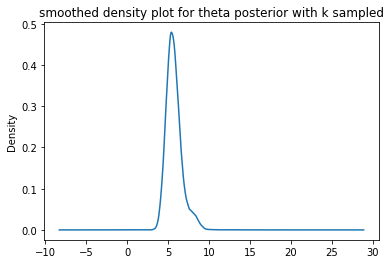

In [25]:
plt.figure()
mchain_ksampled_dataframe.iloc[0,:].plot(kind="density")
plt.title("smoothed density plot for theta posterior with k sampled")

Text(0.5, 1.0, 'smoothed density plot for lambda posterior with k sampled')

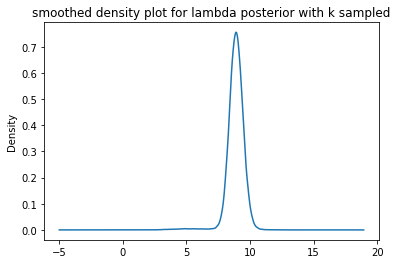

In [26]:
plt.figure()
mchain_ksampled_dataframe.iloc[1,:].plot(kind="density")
plt.title("smoothed density plot for lambda posterior with k sampled")

Text(0.5, 1.0, 'histogram for k posterior with k sampled')

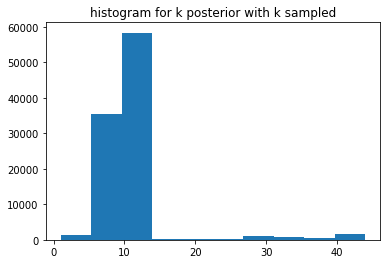

In [27]:
plt.figure()
plt.hist(mchain_ksampled[2,:])
plt.title("histogram for k posterior with k sampled")

In [28]:
# find the posterior probability that lambda is greater than 10 with k sampled
boolean3 = [i for i in mchain_ksampled[1,:] if i > 10]
print("posterior probability that lambda is greater than 10 with k sampled is", len(boolean3)/len(mchain_ksampled[1,:]))

posterior probability that lambda is greater than 10 with k sampled is 0.02251


Plotting the graphs of the last 1000 values only

(array([1.81766904e-10, 1.99757021e-15, 1.99757021e-15, 1.99757021e-15,
        1.99757021e-15, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.99757021e-15, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.99757021e-15]),
 array([8.44637339e-01, 5.50118885e+09, 1.10023777e+10, 1.65035666e+10,
        2.20047554e+10, 2.75059443e+10, 3.30071331e+10, 3.85083220e+10,
        4.40095108e+10, 4.95106997e+10, 5.50118885e+10, 6.05130774e+10,
        6.60142662e+10, 7.15154551e+10, 7.70166439e+10, 8.25178328e+10,
        8.80190217e+10, 9.35202105e+10, 9.90213994e+10, 1.04522588e+11,
        1.10023777e+11, 1.15524966e+11, 1.21026155e+11, 1.26527344e+11,
        1.32028532e+11

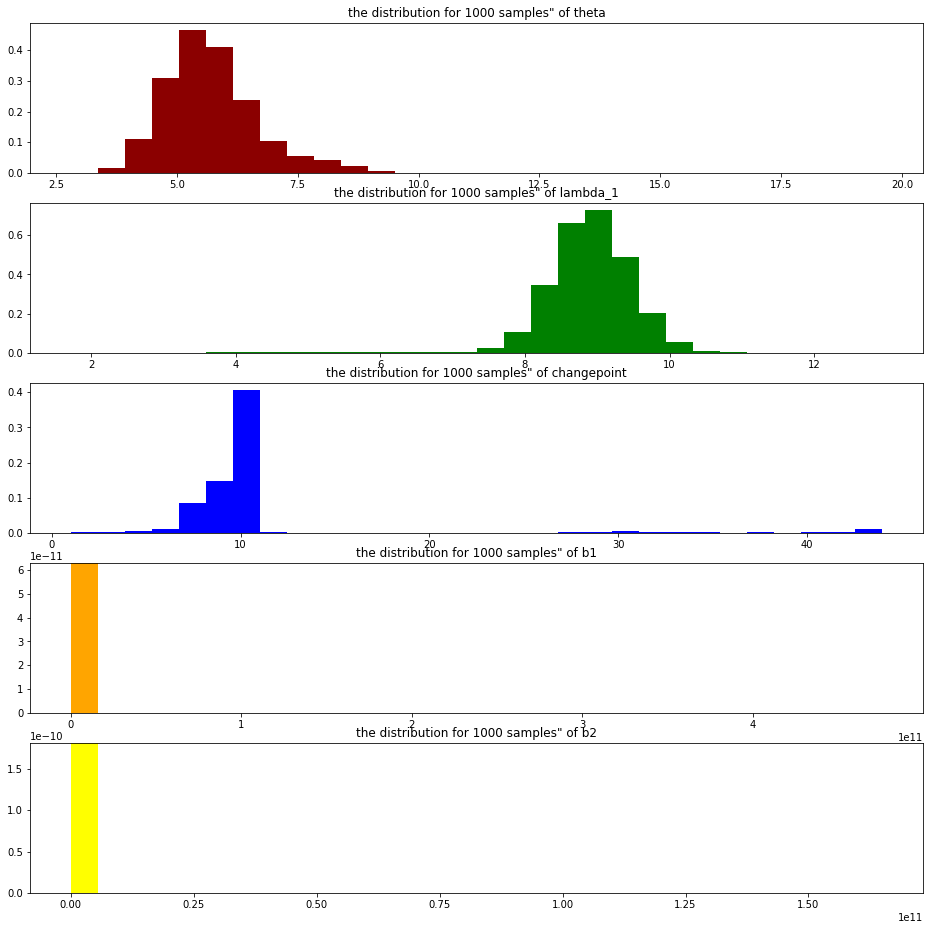

In [29]:
plt.figure(figsize=(16,16))
plt.subplot(511)
plt.title(r"""the distribution for 1000 samples" of theta""")
plt.hist(mchain_ksampled[0,9000:], histtype = "stepfilled", color = "darkred",
         bins = 30, alpha = 1.0, density = True)

plt.subplot(512)
plt.title(r"""the distribution for 1000 samples" of lambda_1""")
plt.hist(mchain_ksampled[1,9000:], histtype = "stepfilled", color = "green",
         bins = 30, alpha = 1.0, density = True)

plt.subplot(513)
plt.title(r"""the distribution for 1000 samples" of changepoint""")
plt.hist(mchain_ksampled[2,9000:], histtype = "stepfilled", color = "blue",
         bins = 30, alpha = 1.0, density = True)

plt.subplot(514)
plt.title(r"""the distribution for 1000 samples" of b1""")
plt.hist(mchain_ksampled[3,9000:], histtype = "stepfilled", color = "orange",
         bins = 30, alpha = 1.0, density = True)

plt.subplot(515)
plt.title(r"""the distribution for 1000 samples" of b2""")
plt.hist(mchain_ksampled[4,9000:], histtype = "stepfilled", color = "yellow",
         bins = 30, alpha = 1.0, density = True)

Summary for the markov chain

In [30]:
pm.summary(mchain_ksampled[0])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,5.729,1.018,3.956,7.688,0.014,0.01,8025.0,3248.0,NaN


In [31]:
pm.summary(mchain_ksampled[1])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,8.872,0.689,7.894,9.991,0.01,0.007,11762.0,5737.0,NaN


In [32]:
pm.summary(mchain_ksampled[2])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,10.561,5.733,5.0,12.0,0.108,0.082,4250.0,2835.0,NaN


In [33]:
pm.summary(mchain_ksampled[3])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,5718032.784,1.514237e+09,0.595,2422.496,4788332.16,3385878.792,97555.0,99239.0,NaN


In [34]:
pm.summary(mchain_ksampled[4])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,3896767.1,6.882633e+08,0.845,3586.981,2176366.534,1538947.111,98117.0,97257.0,NaN


# Model Checking for case 1b
There are 2 components for model checking 
1. Convergence diagonstics
2. Goodness of fit

# 1. Convergence diagonstics
This includes:\
a. different starting values\
b. autocorrelation plots\
c. r_hat statistic\
d. credible intervals and r_hat statistic\
e. effective sample size

a. Different Initial Values\
Take Theta = 1, 5, 10, 15, 20, 25\
Take Lambda_1 = 1, 5, 10, 15, 20, 25\
Take checkpoint = 1, 5, 10, 15, 20, 25

In [35]:
# Programming an MCMC algorithm in Python
# MCMC algorithm for a Bayesian single change point model with k also sampled

KGUESS = 10

def mhsampler_ksampled(NUMIT=1000, dat=Y, init_T=1, init_A=1, init_K=23, init_B1=1, init_B2=1):
    n = dat.size
    print("n=", n)
    # set up matrix to store Markov chain values
    mchain = np.empty((5, NUMIT))
    acc = 0 # count number of accepted proposals (for k only)
    
    # starting values for markov chain
    mchain[:,0] = np.array([init_T, init_A, init_K, init_B1, init_B2])
    
    # loop
    for i in range(1, NUMIT):
        
        # most up to date state for each parameter
        currtheta = mchain[0, i-1]
        currlambda = mchain[1, i-1]
        currk = mchain[2, i-1]
        currb1 = mchain[3, i-1]
        currb2 = mchain[4, i-1]
        
        # sample from full conditional distribution of theta (Gibbs update)
        currtheta = np.random.gamma(shape=sum(Y.iloc[:int(currk)])+0.5, scale=currb1/(currk*currb1 + 1))
        
        # sample from full conditional distribution of lambda (Gibbs update)
        currlambda = np.random.gamma(shape=sum(Y.iloc[int(currk):])+0.5, scale=currb2/((n-currk)*currb2+1))
        
        # sample from full conditional distribution of k (Metropolis-Hastings update)
        propk = np.random.randint(1, n-1)  # draw one sample at random from uniform{1,...,n-1}
        
        # Metropolis accept-reject step (in log scale)
        logMHratio = (sum(Y.iloc[:int(propk)])*log(currtheta) + sum(Y.iloc[int(propk):])*log(currlambda) - propk*currtheta 
                     - (n-propk)*currlambda - (sum(Y.iloc[:int(currk)])*log(currtheta) + sum(Y.iloc[int(currk):])*log(currlambda) 
                                               - currk*currtheta - (n-currk)*currlambda))
        logalpha = min(0, logMHratio)  # alpha = min(1, MHratio)
        # accept if unif(0,1)<alpha, i.e. accept with probability alpha, else stay at current state
        if log(np.random.random()) < logalpha:
            acc += 1
            currk = propk
        
        # currk = KGUESS  # now we do sample k (k not fixed)
        
        # sample from full conditional distribution of b1 (Gibbs update): draw from Inverse Gamma
        currb1 = 1/np.random.gamma(shape=0.5, scale=1/(currtheta+1))
        
        # sample from full conditional distribution of b2 (Gibbs update): draw from Inverse Gamma
        currb2 = 1/np.random.gamma(shape=0.5, scale=1/(currlambda+1))
        
        # update chain with new values
        mchain[:,i] = np.array([currtheta, currlambda, currk, currb1, currb2])
        
    return mchain

In [36]:
#Take Theta = 1, 5, 10, 15, 20, 25
m1 = mhsampler_ksampled(10000, Y, init_T = 1)
m2 = mhsampler_ksampled(10000, Y, init_T = 5)
m3 = mhsampler_ksampled(10000, Y, init_T = 10)
m4 = mhsampler_ksampled(10000, Y, init_T = 15)
m5 = mhsampler_ksampled(10000, Y, init_T = 20)
m6 = mhsampler_ksampled(10000, Y, init_T = 25)

n= 46
n= 46
n= 46
n= 46
n= 46
n= 46


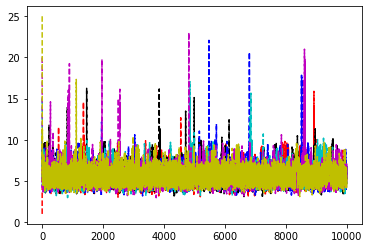

In [37]:
plt.plot(m1[0,:], 'r--')
plt.plot(m2[0,:], 'k--')
plt.plot(m3[0,:], 'b--')
plt.plot(m4[0,:], 'c--')
plt.plot(m5[0,:], 'm--')
plt.plot(m6[0,:], 'y--')

In [38]:
#Take Alpha = 1, 5, 10, 15, 20, 25
m1 = mhsampler_ksampled(10000, Y, init_A = 1)
m2 = mhsampler_ksampled(10000, Y, init_A = 5)
m3 = mhsampler_ksampled(10000, Y, init_A = 10)
m4 = mhsampler_ksampled(10000, Y, init_A = 15)
m5 = mhsampler_ksampled(10000, Y, init_A = 20)
m6 = mhsampler_ksampled(10000, Y, init_A = 25)

n= 46
n= 46
n= 46
n= 46
n= 46
n= 46


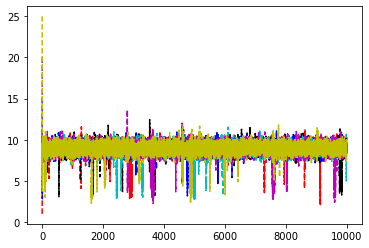

In [39]:
plt.plot(m1[1,:], 'r--')
plt.plot(m2[1,:], 'k--')
plt.plot(m3[1,:], 'b--')
plt.plot(m4[1,:], 'c--')
plt.plot(m5[1,:], 'm--')
plt.plot(m6[1,:], 'y--')

In [40]:
#Take changepoint = 1, 5, 10, 15, 20, 25
m1 = mhsampler_ksampled(10000, Y, init_K = 1)
m2 = mhsampler_ksampled(10000, Y, init_K = 5)
m3 = mhsampler_ksampled(10000, Y, init_K = 10)
m4 = mhsampler_ksampled(10000, Y, init_K = 15)
m5 = mhsampler_ksampled(10000, Y, init_K = 20)
m6 = mhsampler_ksampled(10000, Y, init_K = 25)

n= 46
n= 46
n= 46
n= 46
n= 46
n= 46


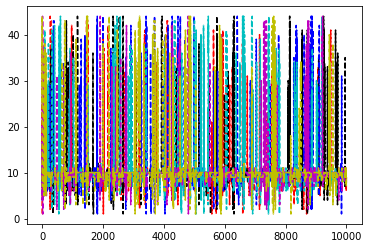

In [41]:
plt.plot(m1[2,:], 'r--')
plt.plot(m2[2,:], 'k--')
plt.plot(m3[2,:], 'b--')
plt.plot(m4[2,:], 'c--')
plt.plot(m5[2,:], 'm--')
plt.plot(m6[2,:], 'y--')

b. Autocorrelation Plots

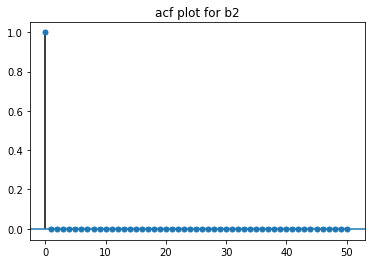

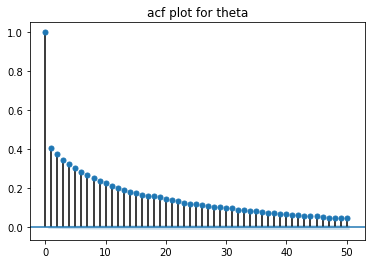

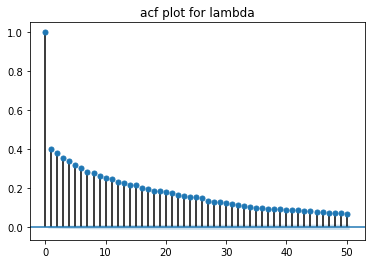

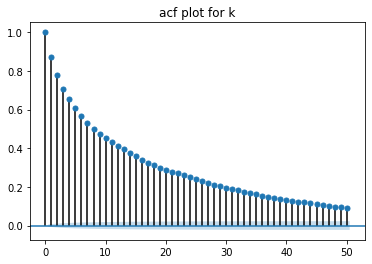

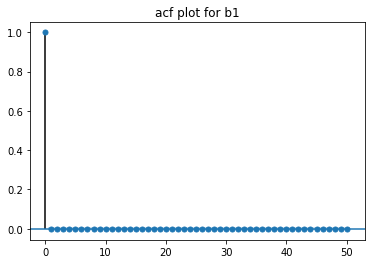

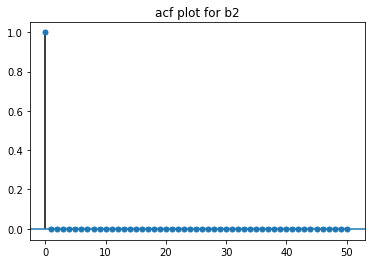

In [42]:
plot_acf(mchain_ksampled[0,:], title="acf plot for theta")
plot_acf(mchain_ksampled[1,:], title="acf plot for lambda")
plot_acf(mchain_ksampled[2,:], title="acf plot for k")
plot_acf(mchain_ksampled[3,:], title="acf plot for b1")
plot_acf(mchain_ksampled[4,:], title="acf plot for b2")

c. rhat statistic

For theta, lambda, changepoint, b1 and b2 respectively

In [44]:
m=np.array([m1[0,:],m2[0,:],m3[0,:],m4[0,:],m5[0,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.001

In [45]:
m=np.array([m1[1,:],m2[1,:],m3[1,:],m4[1,:],m5[1,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.0

In [46]:
m=np.array([m1[2,:],m2[2,:],m3[2,:],m4[2,:],m5[2,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.007

In [47]:
m=np.array([m1[3,:],m2[3,:],m3[3,:],m4[3,:],m5[3,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.0

In [48]:
m=np.array([m1[4,:],m2[4,:],m3[4,:],m4[4,:],m5[4,:]])
m=az.convert_to_dataset(m)
az.rhat(m)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 1.0

all rhat statistic is around 1

d. credible intervals

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000240252B3FC8>],
      dtype=object)

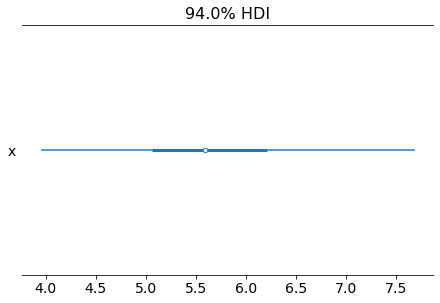

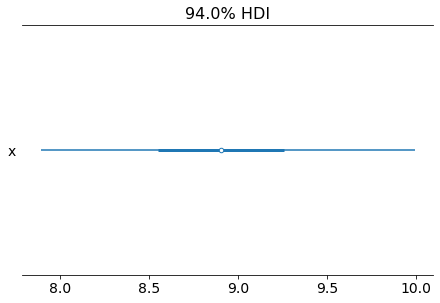

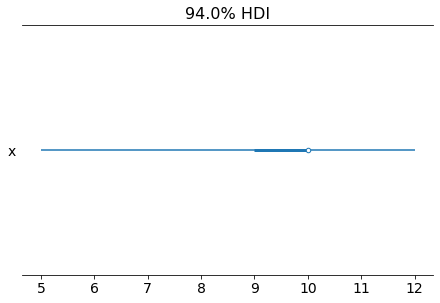

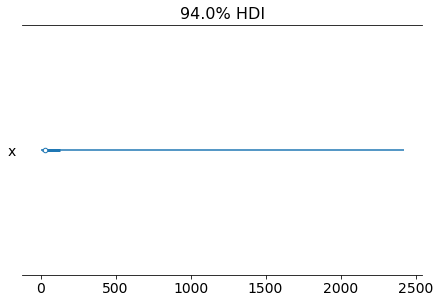

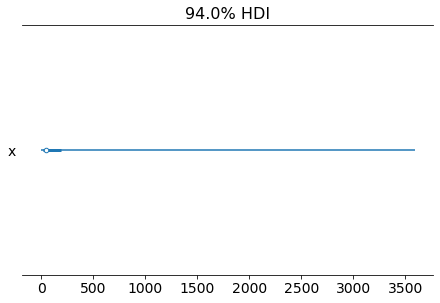

In [49]:
from arviz import plot_forest
plot_forest(mchain_ksampled[0])
plot_forest(mchain_ksampled[1])
plot_forest(mchain_ksampled[2])
plot_forest(mchain_ksampled[3])
plot_forest(mchain_ksampled[4])

e. Effective sample size

In [50]:
print("Effective sample size for theta is", az.ess(mchain_ksampled[0]))
print("Effective sample size for lambda is", az.ess(mchain_ksampled[1]))
print("Effective sample size for changepoint is", az.ess(mchain_ksampled[2]))
print("Effective sample size for b1 is", az.ess(mchain_ksampled[3]))
print("Effective sample size for b2 is", az.ess(mchain_ksampled[4]))

Effective sample size for theta is 8024.868386302932
Effective sample size for lambda is 11762.480514034962
Effective sample size for changepoint is 4250.469424387508
Effective sample size for b1 is 97554.9186196996
Effective sample size for b2 is 98116.57844787586


# 2. Goodness of fit
Evaluating model fit by comparing model predictions with the observations used to fit the model.